In [ ]:
articles = [
    {'title': 'Article 1', 'text': 'This is the text of article 1.'},
    {'title': 'Article 2', 'text': 'This is the text of article 2.'},]

In [ ]:
!pip install gensim nltk
import nltk
nltk.download('stopwords')
import gensim
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def preprocess(text):
  tokens = simple_preprocess(text, deacc=True)
  return [t for t in tokens if t not in stop_words]

# These lines were incorrectly indented, moving them out of the function.
docs = [preprocess(article['text']) for article in articles]
dictionary = Dictionary(docs)
corpus = [dictionary.doc2bow(doc) for doc in docs]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,
    passes=10,
    alpha='auto',
    eta='auto',
    random_state=42
)

In [ ]:
for i, topic in lda_model.print_topics():
    print(f"Topic {i}: {topic}")

Topic 0: 0.500*"article" + 0.500*"text"
Topic 1: 0.500*"article" + 0.500*"text"
Topic 2: 0.500*"article" + 0.500*"text"
Topic 3: 0.500*"text" + 0.500*"article"
Topic 4: 0.500*"article" + 0.500*"text"
Topic 5: 0.500*"text" + 0.500*"article"
Topic 6: 0.500*"article" + 0.500*"text"
Topic 7: 0.500*"text" + 0.500*"article"
Topic 8: 0.500*"article" + 0.500*"text"
Topic 9: 0.500*"article" + 0.500*"text"


In [ ]:
doc_topics = [lda_model.get_document_topics(doc) for doc in corpus]

In [ ]:
import pandas as pd
df = pd.DataFrame({
    'title': [a['title'] for a in articles],
    'topic_dist': doc_topics,
    'date': [a['date'] for a in articles] # Add the date column
})

In [ ]:
for t in range(10):
    df[f'topic_{t}'] = df['topic_dist'].apply(lambda dist: dict(dist).get(t, 0)
    )

In [ ]:
df['week'] = df['date'].dt.to_period('W')
topic_trends = df.groupby('week') [[f'topic_{i}' for i in range(10)]].mean()

In [ ]:
from datetime import datetime

# Assuming your 'articles' list is already defined as:
# articles = [
#     {'title': 'Article 1', 'text': 'This is the text of article 1.'},
#     {'title': 'Article 2', 'text': 'This is the text of article 2.'}
# ]

# Example of adding a 'date' key to each article
# You should replace these with your actual article dates
articles[0]['date'] = datetime(2023, 1, 10)
articles[1]['date'] = datetime(2023, 1, 15)

# Print the modified articles to verify
print(articles)

[{'title': 'Article 1', 'text': 'This is the text of article 1.', 'date': datetime.datetime(2023, 1, 10, 0, 0)}, {'title': 'Article 2', 'text': 'This is the text of article 2.', 'date': datetime.datetime(2023, 1, 15, 0, 0)}]


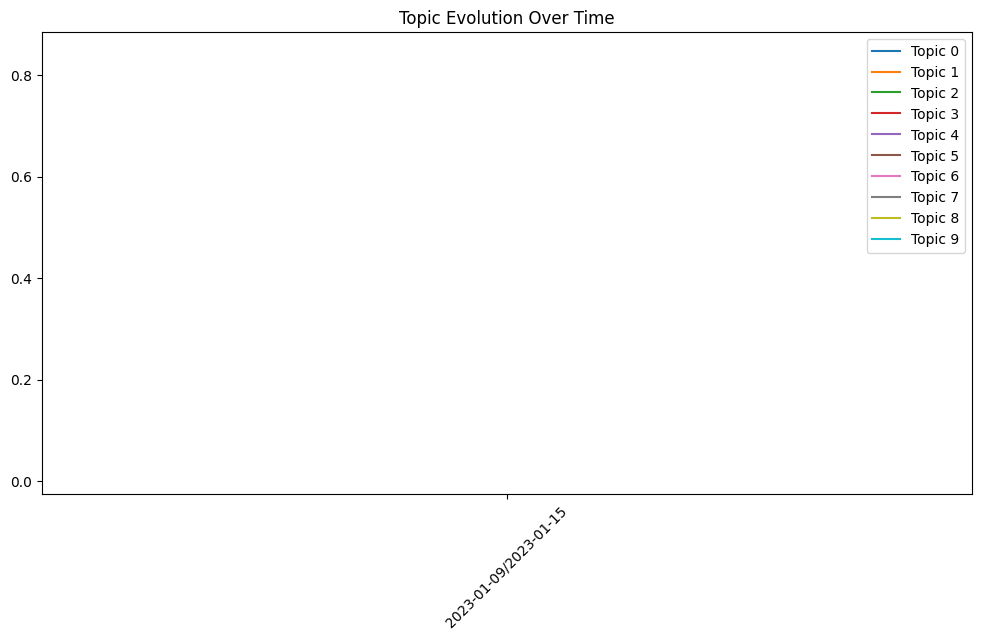

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.plot(topic_trends.index.astype(str), topic_trends[f'topic_{i}'], label=f'Topic {i}')
plt.legend()
plt.title("Topic Evolution Over Time")
plt.xticks(rotation=45)
plt.show()

In [ ]:
pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 28.0 MB/s eta 0:00:00


In [ ]:
import pyLDAvis
import pyLDAvis.gensim

vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

In [ ]:
topic_vectors = df[[f'topic_{i}' for i in range (10)]].values

In [ ]:
from sklearn.cluster import KMeans

k = 2 # Reduced k to be less than or equal to the number of samples (articles)
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(topic_vectors)
df['cluster'] = clusters

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [ ]:
df.groupby('cluster').head(3)

,title,topic_dist,date,week,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,cluster
0,Article 1,"[(0, 0.016077643), (1, 0.016077604), (2, 0.027...",2023-01-10,2023-01-09/2023-01-15,0.016078,0.016078,0.027796,0.016078,0.016077,0.843583,0.016078,0.016078,0.016078,0.016078,0
1,Article 2,"[(0, 0.016077643), (1, 0.016077604), (2, 0.027...",2023-01-15,2023-01-09/2023-01-15,0.016078,0.016078,0.027796,0.016078,0.016077,0.843583,0.016078,0.016078,0.016078,0.016078,0


/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


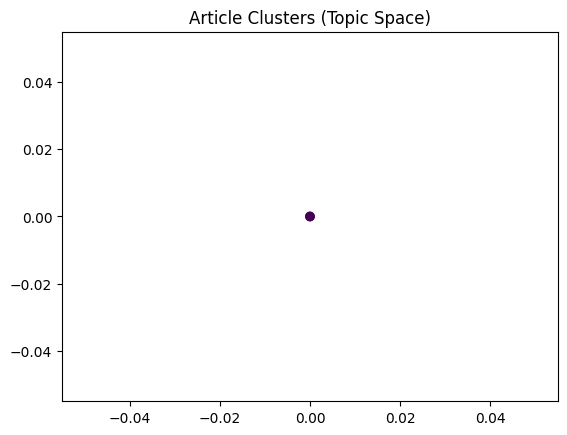

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
topic_vectors_2d = pca.fit_transform(topic_vectors)

plt.scatter(topic_vectors_2d[:,0], topic_vectors_2d[:,1], c=clusters)
plt.title("Article Clusters (Topic Space)")
plt.show()